# Phase 2 Project Notebook -- Jamie Dowat 

#### Project Goals:

* Develop at least 2 variables that are well-modeled with price.
* At least 3 polished visualizations, including a QQ plot

## Business Understanding

* Who are the stakeholders in this project? Who will be directly affected by the creation of this project?
    * If you are struggling to define a stakeholder, we recommend you complete a project for a real estate agency that helps homeowners buy and/or sell homes. A business problem you could focus on for this stakeholder is the need to provide advice to homeowners about how home renovations might increase the estimated value of their homes, and by what amount.


* What business problem(s) will this Data Science project solve for the organization?
    * What factors maximize a home's value?
    

* What problems are inside the scope of this project?
* What problems are outside the scope of this project?
* What data sources are available to us?
* What is the expected timeline for this project? Are there hard deadlines (e.g. "must be live before holiday season shopping") or is this an ongoing project?
* Do stakeholders from different parts of the company or organization all have the exact same understanding about what this project is and isn't?

## Data Understanding

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
from statsmodels.formula.api import ols
import scipy.stats as stats


%matplotlib inline

In [77]:
df = pd.read_csv('../src/kc_house_data.csv')

In [78]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [79]:
len(df)

21597

In [80]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [81]:
df.corr().price

id              -0.016772
price            1.000000
bedrooms         0.308787
bathrooms        0.525906
sqft_living      0.701917
sqft_lot         0.089876
floors           0.256804
waterfront       0.276295
view             0.395734
condition        0.036056
grade            0.667951
sqft_above       0.605368
yr_built         0.053953
yr_renovated     0.129599
zipcode         -0.053402
lat              0.306692
long             0.022036
sqft_living15    0.585241
sqft_lot15       0.082845
Name: price, dtype: float64

In [82]:
df.view.value_counts()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

### Grouping Data 

* .mode() -- the mode of the column
* .count() -- the count of the total number of entries in a column
* .std() -- the standard deviation for the column
* .var() -- the variance for the column
* .sum() -- the sum of all values in the column
* .cumsum() -- the cumulative sum, where each cell index contains the sum of all indices lower than, and including, itself.

##### New Column : Price_per_sqft

In [83]:
df['price_per_sqft'] = df['price'] / df['sqft_living']

In [84]:
df[df['price_per_sqft']==df['price_per_sqft'].max()]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft
19321,6021500970,4/7/2015,874950.0,2,1.0,1080,4000,1.0,0.0,0.0,...,1080,?,1940,NaN,98117,47.6902,-122.387,1530,4240,810.138889


In [85]:
df[df['price_per_sqft']==df['price_per_sqft'].min()]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft
18248,2891000610,12/11/2014,148900.0,4,1.75,1700,6000,1.0,0.0,0.0,...,1700,0.0,1967,0.0,98002,47.3252,-122.208,1280,6000,87.588235


###### New Column : Month Sold

In [86]:
df.date.dtype

dtype('O')

In [87]:
df['month_sold'] = df['date'].map(lambda x: int(x.split('/')[0]))

In [88]:
df['month_sold'].value_counts()

5     2414
4     2229
7     2211
6     2178
8     1939
10    1876
3     1875
9     1771
12    1470
11    1409
2     1247
1      978
Name: month_sold, dtype: int64

###### New Column: incorporated vs not incorporated

In [89]:
unincorporated_zipcodes = [98019, 98014, 98024, 98065, 98038, 98051, 98022, 98045, 98288, 98224,98051, 98027, 98029, 98014, 98077, 98053, 98010, 98027, 98070]
df['unincorporated'] = np.where(df['zipcode'].isin(unincorporated_zipcodes), 1, 0)

In [90]:
df['unincorporated'].value_counts()

0    18302
1     3295
Name: unincorporated, dtype: int64

In [91]:
df_grade_mean = df.groupby('grade').mean()

In [92]:
df_grade_count = df.groupby('grade').count()

In [93]:
df.groupby('grade').boxplot

<bound method boxplot_frame_groupby of <pandas.core.groupby.generic.DataFrameGroupBy object at 0x7f9b7eda6760>>

In [94]:
df.groupby('grade')['price'].agg([np.mean,np.median])

,mean,median
grade,,
3,2.620000e+05,262000.0
4,2.120019e+05,200000.0
5,2.485240e+05,228700.0
6,3.019166e+05,275276.5
7,4.025946e+05,375000.0
8,5.429868e+05,510000.0
9,7.737382e+05,720000.0
10,1.072347e+06,914327.0
11,1.497792e+06,1280000.0


In [95]:
grade_mean_median = df.groupby('grade')['price_per_sqft'].agg([np.mean,np.median])

In [96]:
df.groupby('grade')['price_per_sqft'].mean().values

array([503.84615385, 342.0123655 , 278.93360926, 270.98989171,
       251.88401441, 258.13953459, 275.83939347, 307.74632471,
       342.47894699, 403.60211783, 483.79669319])

<AxesSubplot:xlabel='price_per_sqft', ylabel='Count'>

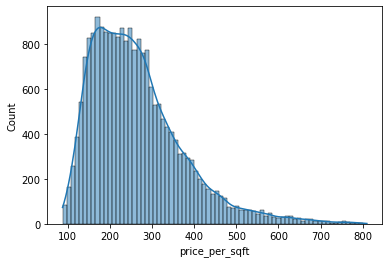

In [97]:
# Distribution of price per square foot
sns.histplot(df['price_per_sqft'], kde=True)

In [98]:
stats.normaltest(df['price_per_sqft'])

NormaltestResult(statistic=4570.848030286431, pvalue=0.0)

In [99]:
stats.skewtest(df['price_per_sqft'])

SkewtestResult(statistic=59.28779807488365, pvalue=0.0)

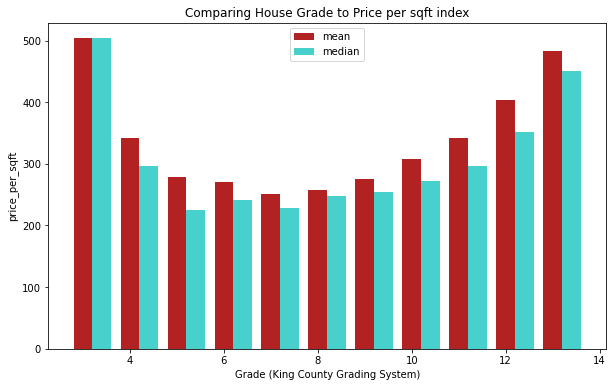

In [100]:
# Bar graph price_per_sqft per grade
fig, ax = plt.subplots(figsize=(10,6))

grade_means = df.groupby('grade')['price_per_sqft'].mean().values
grade_medians = df.groupby('grade')['price_per_sqft'].median().values

w = 0.4
bar1 = [i for i in range(3,14)]
bar2 = [i+w for i in bar1]

ax.bar(bar1, grade_means, width=w, color='firebrick', label='mean', align='center')
ax.bar(bar2, grade_medians, width=w, color='mediumturquoise', label='median', align='center')

# x and y vals; use bottom parameter to make stacked
ax.set_xlabel('Grade (King County Grading System)')
ax.set_ylabel('price_per_sqft')
ax.set_title('Comparing House Grade to Price per sqft index')
ax.legend()

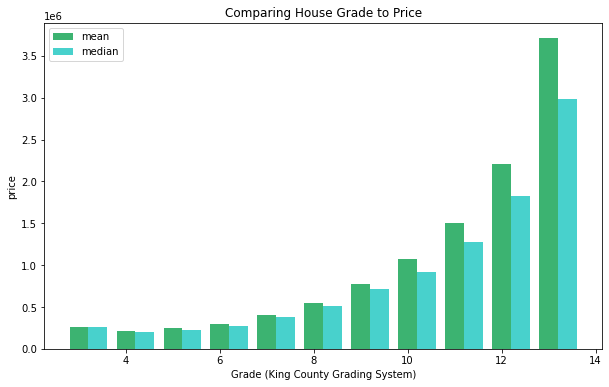

In [101]:
fig, ax = plt.subplots(figsize=(10,6))

grade_means = df.groupby('grade')['price'].mean().values
grade_medians = df.groupby('grade')['price'].median().values

w = 0.4
bar1 = [i for i in range(3,14)]
bar2 = [i+w for i in bar1]

ax.bar(bar1, grade_means, width=w, color='mediumseagreen', label='mean', align='center')
ax.bar(bar2, grade_medians, width=w, color='mediumturquoise', label='median', align='center')

# x and y vals; use bottom parameter to make stacked
ax.set_xlabel('Grade (King County Grading System)')
ax.set_ylabel('price')
ax.set_title('Comparing House Grade to Price')
ax.legend()

In [102]:
df.groupby('grade')['price'].count()

grade
3        1
4       27
5      242
6     2038
7     8974
8     6065
9     2615
10    1134
11     399
12      89
13      13
Name: price, dtype: int64

In [104]:
# not a great distribution of condition qualities-- what does a '3' mean?
df.condition.value_counts()

3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64

In [105]:
df.yr_built.value_counts()

2014    559
2006    453
2005    450
2004    433
2003    420
       ... 
1933     30
1901     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64

Text(0.5, 1.0, 'Year Built vs Average Price')

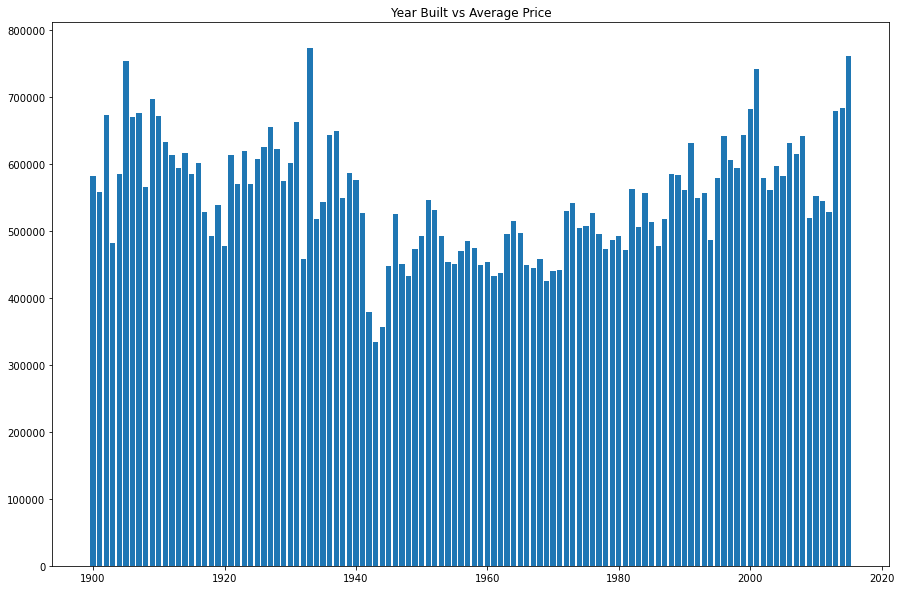

In [106]:
# Avg Sale Price vs Year built
years = sorted(df.yr_built.value_counts().index)
avg_prices = [df['price'][df['yr_built']==year].mean() for year in years]

fig, ax = plt.subplots(figsize=(15,10))
ax.bar(years, avg_prices)
ax.set_title('Year Built vs Average Price')

<AxesSubplot:xlabel='price', ylabel='Count'>

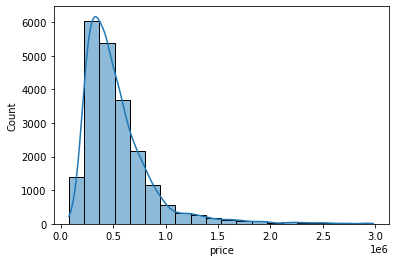

In [107]:
# Distribution of prices
sns.histplot(df['price'][df['price']<3000000], bins=20, kde=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9b7fd91940>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9b7fd9e040>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9b7fd915e0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9b7fd9e700>],
 'fliers': [],
 'means': []}

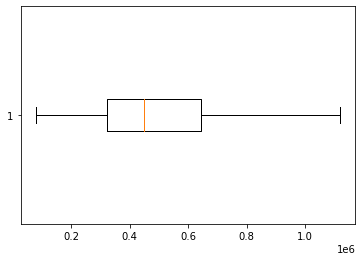

In [108]:
# Prices Boxplot

plt.boxplot(df['price'], showfliers=False, vert=False)

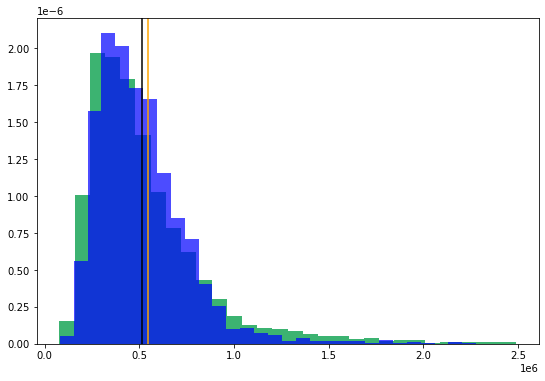

In [109]:
# comparing price distributions for uninc and inc areas
inc = df['price'][(df['unincorporated']==0)&(df['price']<2500000)]
uninc = df['price'][(df['unincorporated']==1)&(df['price']<2500000)]

fig, ax = plt.subplots(figsize=(9,6))

ax.hist(inc, bins=30, color='mediumseagreen', density=True) # inc
ax.hist(uninc, bins=30, color='blue', density=True, alpha=.7) # not inc

ax.axvline(x=df['price'][(df['unincorporated']==0)].mean(), color='orange') # incorporated
ax.axvline(x=df['price'][(df['unincorporated']==1)].mean(), color='black') # not inc

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

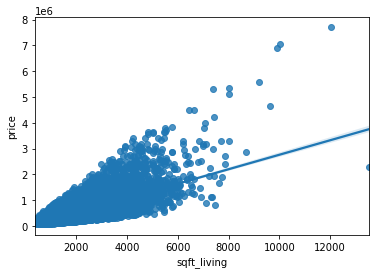

In [110]:
# Distribution of sqft_living and price
sns.regplot(x=df.sqft_living, y=df.price)

In [111]:
mod1 = df[['price', 'sqft_living', 'sqft_living15','price_per_sqft', 'grade', 'bathrooms']]

In [112]:
formula = 'price~sqft_living'
sqft_mod = ols(formula=formula, data=mod1).fit()
sqft_summ = sqft_mod.summary()
sqft_summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Tue, 16 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:56:27   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### HIGHEST RUNNING R^2 

In [113]:
formula = 'price~bathrooms+sqft_living+grade+sqft_living15'
sqft_mod = ols(formula=formula, data=mod1).fit()
sqft_summ = sqft_mod.summary()
sqft_summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     6274.
Date:                Tue, 16 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:56:28   Log-Likelihood:            -2.9906e+05
No. Observations:               21597   AIC:                         5.981e+05
Df Residuals:                   21592   BIC:                         5.982e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -5.993e+05   1.33e+04    -44.909      0.000   -6.25e+05   -5.73e+05
bathrooms     -3.756e+04   3464.703    -10.840      0.000   -4.43e+04   -3.08e+04
sqft_living     198.2797      3.726     53.217      0.000     190.977     205.583
grade          1.022e+05   2430.542     42.066      0.000    9.75e+04    1.07e+05
sqft_living15    11.8674      4.021      2.951      0.003       3.985      19.750
==============================================================================
Omnibus:                    17014.940   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1037908.656
Skew:                           3.311   Prob(JB):                         0.00
Kurtosis:                      36.310   Cond. No.                     2.44e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.44e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [114]:
formula = 'price~bathrooms+sqft_living'
sqft_mod = ols(formula=formula, data=mod1).fit()
sqft_summ = sqft_mod.summary()
sqft_summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 1.049e+04
Date:                Tue, 16 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:56:28   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21594   BIC:                         6.002e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -3.992e+04   5237.187     -7.622      0.000   -5.02e+04   -2.97e+04
bathrooms   -5095.2734   3535.830     -1.441      0.150    -1.2e+04    1835.215
sqft_living   284.0883      2.962     95.926      0.000     278.284     289.893
==============================================================================
Omnibus:                    14783.268   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           540478.758
Skew:                           2.815   Prob(JB):                         0.00
Kurtosis:                      26.852   Cond. No.                     7.27e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [115]:
formula = 'price_per_sqft~grade'
sqft_mod = ols(formula=formula, data=mod1).fit()
sqft_summ = sqft_mod.summary()
sqft_summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         price_per_sqft   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     343.9
Date:                Tue, 16 Feb 2021   Prob (F-statistic):           3.54e-76
Time:                        10:56:28   Log-Likelihood:            -1.3199e+05
No. Observations:               21597   AIC:                         2.640e+05
Df Residuals:                   21595   BIC:                         2.640e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    174.2486      4.904     35.531      0.000     164.636     183.861
grade         11.7388      0.633     18.544      0.000      10.498      12.980
==============================================================================
Omnibus:                     4672.028   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9902.630
Skew:                           1.267   Prob(JB):                         0.00
Kurtosis:                       5.142   Cond. No.                         52.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [116]:
formula = 'price~grade'
sqft_mod = ols(formula=formula, data=mod1).fit()
sqft_summ = sqft_mod.summary()
sqft_summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                 1.740e+04
Date:                Tue, 16 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:56:28   Log-Likelihood:            -3.0101e+05
No. Observations:               21597   AIC:                         6.020e+05
Df Residuals:                   21595   BIC:                         6.020e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.061e+06   1.23e+04    -86.396      0.000   -1.09e+06   -1.04e+06
grade       2.092e+05   1585.790    131.895      0.000    2.06e+05    2.12e+05
==============================================================================
Omnibus:                    19879.964   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2043898.709
Skew:                           4.081   Prob(JB):                         0.00
Kurtosis:                      49.954   Cond. No.                         52.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [117]:
formula = 'price~grade+sqft_living'
sqft_mod = ols(formula=formula, data=mod1).fit()
sqft_summ = sqft_mod.summary()
sqft_summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                 1.241e+04
Date:                Tue, 16 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:56:28   Log-Likelihood:            -2.9913e+05
No. Observations:               21597   AIC:                         5.983e+05
Df Residuals:                   21594   BIC:                         5.983e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -6.028e+05   1.33e+04    -45.181      0.000   -6.29e+05   -5.77e+05
grade        9.925e+04   2247.784     44.155      0.000    9.48e+04    1.04e+05
sqft_living   184.1215      2.872     64.102      0.000     178.491     189.751
==============================================================================
Omnibus:                    16960.955   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1005795.090
Skew:                           3.304   Prob(JB):                         0.00
Kurtosis:                      35.773   Cond. No.                     1.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [118]:
formula = 'price_per_sqft~grade'
sqft_mod = ols(formula=formula, data=mod1).fit()
sqft_summ = sqft_mod.summary()
sqft_summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         price_per_sqft   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     343.9
Date:                Tue, 16 Feb 2021   Prob (F-statistic):           3.54e-76
Time:                        10:56:29   Log-Likelihood:            -1.3199e+05
No. Observations:               21597   AIC:                         2.640e+05
Df Residuals:                   21595   BIC:                         2.640e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    174.2486      4.904     35.531      0.000     164.636     183.861
grade         11.7388      0.633     18.544      0.000      10.498      12.980
==============================================================================
Omnibus:                     4672.028   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9902.630
Skew:                           1.267   Prob(JB):                         0.00
Kurtosis:                       5.142   Cond. No.                         52.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [119]:
df[df['price']>3000000].max()

id                9808700762
date                9/4/2014
price                7.7e+06
bedrooms                   8
bathrooms                  8
sqft_living            12050
sqft_lot               56609
floors                   3.5
waterfront                 1
view                       4
condition                  5
grade                     13
sqft_above              8860
sqft_basement              ?
yr_built                2014
yr_renovated            2010
zipcode                98199
lat                  47.7493
long                -122.077
sqft_living15           5070
sqft_lot15             51330
price_per_sqft       798.122
month_sold                12
unincorporated             0
dtype: object

###### Waterfront views? 

In [120]:
df_wf = df
df_wf.dropna(inplace=True, subset=['waterfront'])

In [121]:
df_wf.isna().sum()

id                   0
date                 0
price                0
bedrooms             0
bathrooms            0
sqft_living          0
sqft_lot             0
floors               0
waterfront           0
view                57
condition            0
grade                0
sqft_above           0
sqft_basement        0
yr_built             0
yr_renovated      3412
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
price_per_sqft       0
month_sold           0
unincorporated       0
dtype: int64

In [122]:
df_wf.waterfront.value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

In [123]:
df_wf['price'][df_wf['waterfront']==1.0].mean()

1717214.7260273972

In [124]:
df_wf['price'][df_wf['waterfront']==0.0].mean()

532641.9866841416

In [125]:
len(df[df['price']>3000000])

44

In [126]:
df[df['price']>3000000].max()

id                9808700762
date                9/4/2014
price                7.7e+06
bedrooms                   8
bathrooms                  8
sqft_living            12050
sqft_lot               56609
floors                   3.5
waterfront                 1
view                       4
condition                  5
grade                     13
sqft_above              8860
sqft_basement              ?
yr_built                2014
yr_renovated            2010
zipcode                98199
lat                  47.7493
long                -122.077
sqft_living15           5070
sqft_lot15             51330
price_per_sqft       798.122
month_sold                12
unincorporated             0
dtype: object

In [127]:
df_wf[(df_wf['waterfront']==1)&(df_wf['price']>7000000)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft,month_sold,unincorporated
3910,9808700762,6/11/2014,7060000.0,5,4.5,10040,37325,2.0,1.0,2.0,...,1940,2001.0,98004,47.65,-122.214,3930,25449,703.187251,6,0


Text(0.5, 1.0, 'Comparing dist of Price per Sqft')

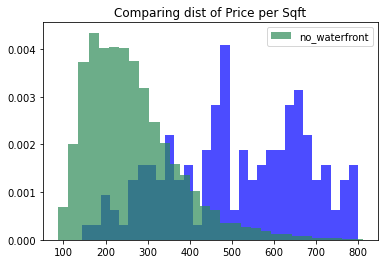

In [128]:
waterfront = df_wf['price_per_sqft'][df_wf['waterfront']==1]
no_waterfront = df_wf['price_per_sqft'][df_wf['waterfront']==0]
plt.hist(waterfront, bins=30, color='blue', density=True, alpha=.7)
plt.hist(no_waterfront, bins=30, color='seagreen', density=True, alpha=.7, label='no_waterfront')
plt.legend()
plt.title('Comparing dist of Price per Sqft')

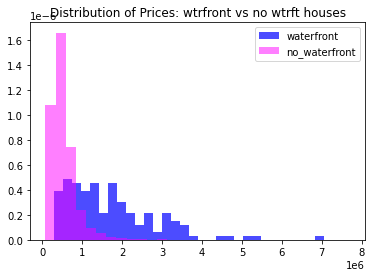

In [129]:
waterfront = df_wf['price'][df_wf['waterfront']==1]
no_waterfront = df_wf['price'][df_wf['waterfront']==0]
plt.hist(waterfront, bins=30, color='blue', density=True, alpha=.7, label='waterfront')
plt.hist(no_waterfront, bins=30, color='magenta', density=True, alpha=.5, label='no_waterfront')
plt.title('Distribution of Prices: wtrfront vs no wtrft houses')
plt.legend()

In [130]:
print(len(waterfront), len(no_waterfront))
# very small minority 

146 19075


In [131]:
df['price'].dtype

dtype('float64')

In [132]:
df[df['condition']<3]['price'].max()

2560000.0

In [133]:
df['yr_renovated'][df['yr_renovated']>=2000].value_counts()

2014.0    64
2013.0    29
2005.0    27
2000.0    25
2007.0    24
2003.0    24
2009.0    19
2006.0    18
2004.0    18
2008.0    15
2002.0    15
2010.0    14
2001.0    14
2015.0    13
2011.0     7
2012.0     7
Name: yr_renovated, dtype: int64

In [134]:
df[df['price']>3000000].max()

id                9808700762
date                9/4/2014
price                7.7e+06
bedrooms                   8
bathrooms                  8
sqft_living            12050
sqft_lot               56609
floors                   3.5
waterfront                 1
view                       4
condition                  5
grade                     13
sqft_above              8860
sqft_basement              ?
yr_built                2014
yr_renovated            2010
zipcode                98199
lat                  47.7493
long                -122.077
sqft_living15           5070
sqft_lot15             51330
price_per_sqft       798.122
month_sold                12
unincorporated             0
dtype: object

In [135]:
# people love bathrooms

# the monster of data science: knowing what to use and what not to use
# it seems like a weird esoteric pyramid scheme

In [137]:
zipcode_per_sqft = df.groupby('zipcode')['price_per_sqft'].mean()
zipcode_per_sqft

zipcode
98001    150.317108
98002    151.703004
98003    156.791293
98004    474.042797
98005    314.950000
            ...    
98177    293.880201
98178    190.736784
98188    168.279432
98198    179.562574
98199    376.243824
Name: price_per_sqft, Length: 70, dtype: float64

HERE's sumthin u cin uz:
.nunique()

###### One Hot Encoding: Month
Watch out for the dummy variable trap

dropped category == reference category

Why drop the first category???

In [142]:
abs(df.corr()) > 0.75

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft,month_sold,unincorporated
id,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
price,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
sqft_lot,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [144]:
df=df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#d rop level columns
df_pairs = df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df_pairs.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df_pairs.drop_duplicates(inplace=True)

AttributeError: 'NoneType' object has no attribute 'columns'

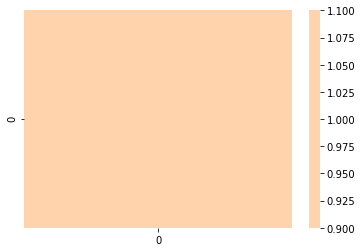

In [145]:
# will this change removing the NaNs for waterfront and yr renovated??
sns.heatmap(df.corr(), center=0);

In [141]:
months_series = pd.Series(df['month_sold'])

cat_months = months_series.astype('category')

# Can concat to original data frame
pd.get_dummies(cat_months, prefix='mo')

,mo_1,mo_2,mo_3,mo_4,mo_5,mo_6,mo_7,mo_8,mo_9,mo_10,mo_11,mo_12
1,0,0,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
21591,0,1,0,0,0,0,0,0,0,0,0,0
21592,0,0,0,0,1,0,0,0,0,0,0,0
21593,0,1,0,0,0,0,0,0,0,0,0,0
21594,0,0,0,0,0,1,0,0,0,0,0,0


## Data Prep

## Modeling